In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

# import _utils # amanda's collected utils

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils
import datetime as dt
import numpy as np

import gcsfs

from calitp_data.storage import get_fs
fs = get_fs()

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_319/1183802640.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  im

# Spatially Join SWITRS Data to Projects

In [2]:
# load projects
with get_fs().open(f'{GCS_FILE_PATH}nonshopp_gdf.geojson') as f:
    all_proj = gpd.read_file(f)

In [3]:
all_proj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 98 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   unnamed:_0                                        129 non-null    int64   
 1   rail_project_id                                   129 non-null    object  
 2   _10_year_plan                                     129 non-null    int64   
 3   ct_project_id                                     125 non-null    object  
 4   ea                                                122 non-null    object  
 5   ppno                                              120 non-null    object  
 6   project_name                                      129 non-null    object  
 7   district                                          129 non-null    object  
 8   county                                            129 non-null    object  
 9   ro

In [4]:
# buffer the projects w/ geometry - start w/ 100ft?
all_proj_geom = (all_proj
                   >> filter(_.geometry.is_valid)
                   )

# re-project
all_proj_geom = all_proj_geom.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

# add buffer - 100 ft ~ 30m
all_proj_geom['b100'] = all_proj_geom.buffer(30)
all_proj_geom['b200'] = all_proj_geom.buffer(61)

all_proj_geom = all_proj_geom.set_geometry('b200')

In [5]:
all_proj_geom.explore(tiles="cartodbpositron")

In [6]:
# load safety data
tims = gpd.read_parquet('gs://calitp-analytics-data/data-analyses/safety_projects/tims_fsi.parquet')

In [7]:
# test mapping crashes only
tims.head(100).explore(tiles="cartodbpositron")

In [8]:
# clip crashes to those within buffer
tims_clip = tims.clip(all_proj_geom)

In [9]:
len(tims_clip)

424

In [10]:
# spatial join - left side is safety data, each obs will be a crash point intersecting the project area
tims_proj = tims.sjoin(all_proj_geom, how='right', predicate='intersects')

In [11]:
# convert ped, bike accident to numeric flags
tims_proj = tims_proj.assign(ped_crash = np.where(tims_proj['PEDESTRIAN_ACCIDENT']=="Y",1,0),
                             bike_crash = np.where(tims_proj['BICYCLE_ACCIDENT']=="Y",1,0)
                            )
tims_proj['pedbike_crash'] = tims_proj[["ped_crash", "bike_crash"]].max(axis=1)

In [12]:
# Aggregate up fatals, severely injured, etc to each project
# can't group by geometry because it's not orderable and there are different types
tims_proj_agg = (tims_proj
                    >> group_by(_.ppno, _.project_name, _.detailed_project_title)
                    >> summarize(sum_killed = _.NUMBER_KILLED.sum(),
                                 sum_injured = _.NUMBER_INJURED.sum(),
                                 sum_crashes = _.CASE_ID.nunique(),
                                 sum_ped = _.ped_crash.sum(),
                                 sum_bike = _.bike_crash.sum(),
                                 sum_pedbike = _.pedbike_crash.sum()
                    )
                                )

In [13]:
# put back project geometry
tims_proj_gdf = gpd.GeoDataFrame(data=(all_proj_geom
                  >> select(_.geometry,_.ppno,_.project_name,_.detailed_project_title)
                  >> right_join(_,tims_proj_agg)
                  ))

In [14]:
tims_proj_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                129 non-null    geometry
 1   ppno                    120 non-null    object  
 2   project_name            129 non-null    object  
 3   detailed_project_title  129 non-null    object  
 4   sum_killed              129 non-null    float64 
 5   sum_injured             129 non-null    float64 
 6   sum_crashes             129 non-null    int64   
 7   sum_ped                 129 non-null    int64   
 8   sum_bike                129 non-null    int64   
 9   sum_pedbike             129 non-null    int64   
dtypes: float64(2), geometry(1), int64(4), object(3)
memory usage: 11.1+ KB


In [15]:
tims_proj_gdf.explore(tiles="cartodbpositron", column="sum_crashes")

Test Metrics:
* n fatalities within 200ft buffer of project area over 5 year lookback period
    * test different temporal study periods; rural may need more time
    * test different buffers; different project types may need different sizes
* n fatalities+severely injured (KSIs) w/in buffer area
* n ped/bike crashes w/in buffer area
* % ped/bike crashes out of all crashes w/in buffer area

array([[<AxesSubplot:title={'center':'sum_crashes'}>]], dtype=object)

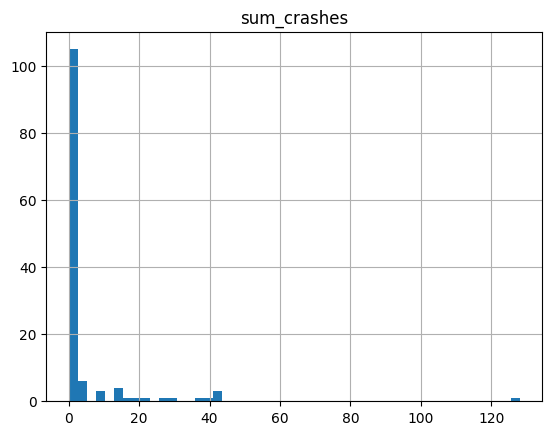

In [16]:
tims_proj_gdf.hist(column='sum_crashes', bins=50)

In [17]:
tims_proj_gdf >> count(_.sum_crashes)

,sum_crashes,n
0,0,89
1,1,16
2,3,3
3,5,3
4,9,1
5,10,2
6,13,1
7,14,3
8,17,1
9,19,1
